# Qualitative evaluation of covariance estimation method in MRSI data

Evaluate the performance of the proposed covariance estimation method (Eqn 7 in the paper) in several signal models.
1. Random low-rank matrix
2. Single peak (on-resonance)
3. Single peak (off-resonance)
4. Simple multi-peak case
5. In vivo simulation

In [1]:
import numpy as np
from mrs_denoising import utils
import matplotlib.pyplot as plt

In [437]:
def run_covariance_analysis(data_func, noise_sd, repetitions=1000):
    data, truncation_rank = data_func()
    shape = data.shape
    store = []
    store_cov = []
    rng = np.random.default_rng()
    for idx in range(repetitions):
        noisy_mat = data\
            + noise_sd/np.sqrt(2) * rng.standard_normal(shape)\
            + 1j * noise_sd/np.sqrt(2) * rng.standard_normal(shape)
        denoised, var, cov = utils.svd_trunc(noisy_mat,r=truncation_rank)
        cov = cov.conj()
        cov = cov - np.diag(np.diag(cov)) + np.diag(var[0,:])
        cov *= noise_sd**2
        store.append(denoised)
        store_cov.append(cov)
        
    store = np.asarray(store)
    store_cov = np.asarray(store_cov)

    mc_covariance = np.cov(store[:,0,:].T)
    est_covariance = np.mean(store_cov, axis=0)
    
    return mc_covariance, est_covariance, (data,noisy_mat,denoised)

## Plotting functions

In [305]:
def FID2Spec(FID, axis=0):
    # By convention the first point of the fid is special-cased
    ss = [slice(None) for i in range(FID.ndim)]
    ss[axis] = slice(0, 1)
    ss = tuple(ss)
    FID[ss] *= 0.5
    out = np.fft.fftshift(
        np.fft.fft(FID,
                   axis=axis,
                   norm='ortho'),axes=axis)
    FID[ss] *= 2
    return out

In [296]:
def plot_real_imag(mc_cov, est_cov, error_display=0.1, limit=None):
    fig, axes = plt.subplots(3,3,figsize=(10,10))
    plot_lim_max = np.max([np.real(mc_cov), np.abs(np.real(mc_cov)), np.imag(mc_cov), np.abs(np.imag(mc_cov))])
    im1 = axes[0][0].matshow(np.real(mc_cov), vmin=-plot_lim_max , vmax=plot_lim_max)
    axes[0][1].matshow(np.imag(mc_cov), vmin=-plot_lim_max , vmax=plot_lim_max)
    axes[0][2].matshow(np.abs(mc_cov), vmin=-plot_lim_max , vmax=plot_lim_max)
    
    im2 = axes[1][0].matshow(np.real(est_cov), vmin=-plot_lim_max , vmax=plot_lim_max)
    axes[1][1].matshow(np.imag(est_cov), vmin=-plot_lim_max , vmax=plot_lim_max)
    axes[1][2].matshow(np.abs(est_cov), vmin=-plot_lim_max , vmax=plot_lim_max)
    
    im3 = axes[2][0].matshow(np.abs(np.real(mc_cov)-np.real(est_cov)), vmin=0 , vmax=plot_lim_max*error_display)
    axes[2][1].matshow(np.abs(np.imag(mc_cov)-np.imag(est_cov)), vmin=0 , vmax=plot_lim_max*error_display)
    axes[2][2].matshow(np.abs(mc_cov-est_cov), vmin=0 , vmax=plot_lim_max*error_display)
    
    for ax in axes.flatten():
        ax.tick_params(top=False, left=False, bottom=False, labeltop=False, labelleft=False)
    
    for ax in axes.flatten():
        ax.set_xlim([0, limit])
        ax.set_ylim([limit, 0])
    
    axes[0][0].set_title('Real',fontsize=18)
    axes[0][1].set_title('Imag',fontsize=18)
    axes[0][2].set_title('Abs',fontsize=18)
    
    axes[0][0].set_ylabel('MC',fontsize=18)
    axes[1][0].set_ylabel('Estimated',fontsize=18)
    axes[2][0].set_ylabel('Abs. difference',fontsize=18)
    
    fig.subplots_adjust(right=0.9)
    cbar_ax1 = fig.add_axes([0.925, 0.66, 0.025, 0.22])
    cb1 = fig.colorbar(im1, cax=cbar_ax1)
    cb1.set_ticks([-plot_lim_max, 0, plot_lim_max])
    cb1.set_ticklabels([-1, 0, 1])
    cbar_ax2 = fig.add_axes([0.925, 0.39, 0.025, 0.22])
    cb2 = fig.colorbar(im2, cax=cbar_ax2)
    cb2.set_ticks([-plot_lim_max, 0, plot_lim_max])
    cb2.set_ticklabels([-1, 0, 1])
    cbar_ax3 = fig.add_axes([0.925, 0.125, 0.025, 0.22])
    cb3 = fig.colorbar(im3, cax=cbar_ax3)
    cb3.set_ticks([0, plot_lim_max*error_display*0.5, plot_lim_max*error_display])
    cb3.set_ticklabels([0, error_display/2, error_display])
    
    plt.show()

In [485]:
def plot_combined(mc_list, est_list, data_list, save_path, error_display=0.1, limit=None):
    ncases = len(mc_list)
    fig, axes = plt.subplots(4,ncases,figsize=(15,12))
    for ndx, (mc_cov,est_cov,data) in enumerate(zip(mc_list, est_list, data_list)):
        plot_lim_max = np.max(np.real(mc_cov))
        
        axes[0][ndx].plot(FID2Spec(data[1][0,:]).real)
        axes[0][ndx].plot(FID2Spec(data[2][0,:]).real)
        im1 = axes[1][ndx].matshow(np.real(mc_cov), vmin=-plot_lim_max , vmax=plot_lim_max)    
        im2 = axes[2][ndx].matshow(np.real(est_cov), vmin=-plot_lim_max , vmax=plot_lim_max)  
        im3 = axes[3][ndx].matshow(np.abs(mc_cov-est_cov), vmin=0 , vmax=plot_lim_max*error_display)
    
    for ax in axes.flatten():
        ax.tick_params(top=False, left=False, bottom=False, labeltop=False, labelleft=False)
    
    for idx in range(1,4):
        for jdx in range(1,5):
            axes[idx][jdx].set_xlim([0, limit])
            axes[idx][jdx].set_ylim([limit, 0])
    
    axes[0][0].set_title('Random\nmatrix',fontsize=18)
    axes[0][1].set_title('Single Peak\n(on-resonance)',fontsize=18)
    axes[0][2].set_title('Single Peak\n(off-resonance)',fontsize=18)
    axes[0][3].set_title('Multi-peak\n(rank 3)',fontsize=18)
    axes[0][4].set_title('Multi-peak\n(rank ~20)',fontsize=18)
    
    axes[1][0].set_ylabel('MC',fontsize=18)
    axes[2][0].set_ylabel('Estimated',fontsize=18)
    axes[3][0].set_ylabel('Abs. difference',fontsize=18)
    
    fig.subplots_adjust(right=0.9)
    cbar_ax1 = fig.add_axes([0.92, 0.52, 0.015, 0.163])
    cb1 = fig.colorbar(im1, cax=cbar_ax1)
    cb1.set_ticks([-plot_lim_max, 0, plot_lim_max])
    cb1.set_ticklabels([-1, 0, 1])
    cbar_ax2 = fig.add_axes([0.92, 0.32, 0.015, 0.163])
    cb2 = fig.colorbar(im2, cax=cbar_ax2)
    cb2.set_ticks([-plot_lim_max, 0, plot_lim_max])
    cb2.set_ticklabels([-1, 0, 1])
    cbar_ax3 = fig.add_axes([0.92, 0.125, 0.015, 0.163])
    cb3 = fig.colorbar(im3, cax=cbar_ax3)
    cb3.set_ticks([0, plot_lim_max*error_display*0.5, plot_lim_max*error_display])
    cb3.set_ticklabels([0, error_display/2, error_display])
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)

## Data generation functions
### Random low rank matrix

In [461]:
def random_mat():
    rng = np.random.default_rng()
    matrix_size_1 = 100
    matrix_size_2 = 30
    m0 = rng.standard_normal((int(matrix_size_1/4),int(matrix_size_2/2)))\
    + 1j*rng.standard_normal((int(matrix_size_1/4),int(matrix_size_2/2)))
    
    m0 = np.concatenate((m0,m0,m0,m0),axis=0)
    m0 = np.concatenate((m0,m0),axis=1)
    rng.shuffle(m0)
    rng.shuffle(m0,axis=1)
    
    rank_threshold = np.linalg.matrix_rank(m0)
    
    return m0, rank_threshold

### Single on-resonance peak and single off resonance peak

In [482]:
def fwd(x, c, alpha, omega, phi):
    return c * np.exp((alpha + 1j * omega) * x) * np.exp(1j * phi)

def generate_single(reps=1, linewidth=10, bandwidth=1000, points=512, shift=0):
    dwelltime = 1 / bandwidth
    time_axis = np.arange(0.0, points*dwelltime, dwelltime)
    
    alpha = -np.pi * linewidth
    noiseless = fwd(time_axis, 1.0, alpha, shift, 0.0)
    
    return np.broadcast_to(noiseless, (reps, points))

def single_peak_on():
    return generate_single(reps=128), 1

def single_peak_off():
    return generate_single(reps=128, shift=100), 1

### Explicit r=3 dataset

In [443]:
def multi_peak_3():

    peak_frequencies = [-200, 0, 300]
    peak_amps = [1, 1, 1]
    peak_lw = [10, 15, 10]
    centre_X = [2, 5, 2]
    centre_Y = [2, 4, 6]

    Nt = 512
    bandwidth = 2000
    dt = 1 / bandwidth
    time_axis = dt * np.arange(0, Nt)

    xx, yy, zz = np.arange(0,8), np.arange(0,8), np.arange(0,1)
    X, Y, Z = np.meshgrid(xx, yy, zz)

    def peak(x, c, omega, alpha, phi=0.0):
        return c * np.exp((alpha + 1j * 2 * np.pi * omega) * x) * np.exp(1j * phi)

    sigma=2
    noiseless = np.zeros(X.shape + (Nt,),dtype=complex)
    weights = []
    for pdx in range(3):
        gauss_weight = np.exp( -((X-centre_X[pdx])**2 + (Y-centre_Y[pdx])**2) / (2.*sigma**2) )
        weights.append(gauss_weight)

        fid = peak(time_axis, peak_amps[pdx], peak_frequencies[pdx], -np.pi * peak_lw[pdx])

        noiseless += gauss_weight[:,:,:,np.newaxis] * fid
        
    return noiseless.reshape(-1,Nt), np.linalg.matrix_rank(noiseless.reshape(-1,Nt))

### Variable multi_peak dataset

In [418]:
def multi_peak(n_peaks=20):
    bandwidth = 2000
    rng = np.random.default_rng()
    peak_frequencies = bandwidth/8 * rng.standard_normal(size=(n_peaks))
    peak_amps = np.ones((n_peaks))
    peak_lw = 10 * rng.random(size=(n_peaks)) + 10
    centre_X = rng.integers(0,high=8,size=(n_peaks))
    centre_Y = rng.integers(0,high=8,size=(n_peaks))

    Nt = 512
    dt = 1 / bandwidth
    time_axis = dt * np.arange(0, Nt)

    xx, yy, zz = np.arange(0,8), np.arange(0,8), np.arange(0,1)
    X, Y, Z = np.meshgrid(xx, yy, zz)

    def peak(x, c, omega, alpha, phi=0.0):
        return c * np.exp((alpha + 1j * 2 * np.pi * omega) * x) * np.exp(1j * phi)

    sigma=2
    noiseless = np.zeros(X.shape + (Nt,),dtype=complex)
    weights = []
    for pdx in range(n_peaks):
        gauss_weight = np.exp( -((X-centre_X[pdx])**2 + (Y-centre_Y[pdx])**2) / (2.*sigma**2) )
        weights.append(gauss_weight)

        fid = peak(time_axis, peak_amps[pdx], peak_frequencies[pdx], -np.pi * peak_lw[pdx])

        noiseless += gauss_weight[:,:,:,np.newaxis] * fid
        
    return noiseless.reshape(-1,Nt), np.linalg.matrix_rank(noiseless.reshape(-1,Nt))

## Generate and plot results individually

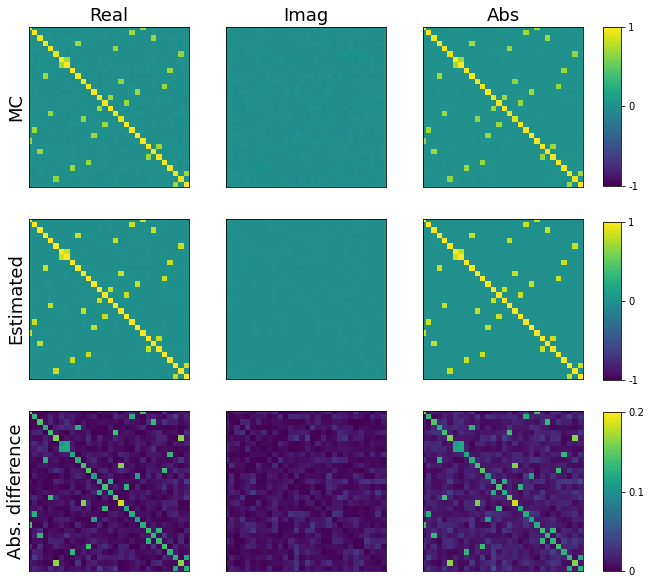

In [462]:
mc_cov_1, est_cov_1, data_1 = run_covariance_analysis(random_mat, 0.1, repetitions=3000)

plot_real_imag(mc_cov_1, est_cov_1, error_display=0.2)

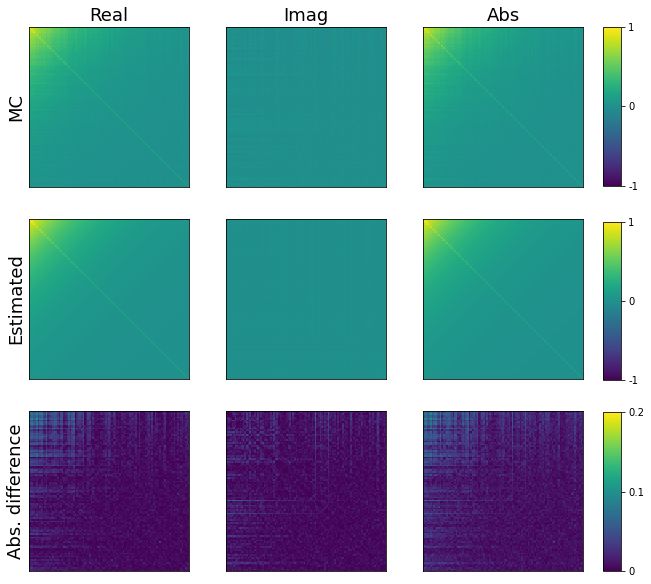

In [314]:
mc_cov_2, est_cov_2, data_2 = run_covariance_analysis(single_peak_on, 0.1, repetitions=200)

plot_real_imag(mc_cov_2, est_cov_2, error_display=0.2, limit=100)

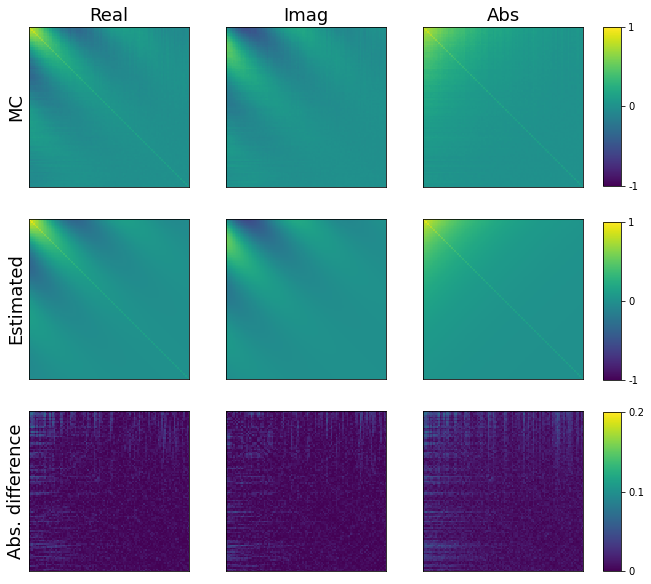

In [315]:
mc_cov_3, est_cov_3, data_3 = run_covariance_analysis(single_peak_off, 0.1, repetitions=200)

plot_real_imag(mc_cov_3, est_cov_3, error_display=0.2, limit=100)

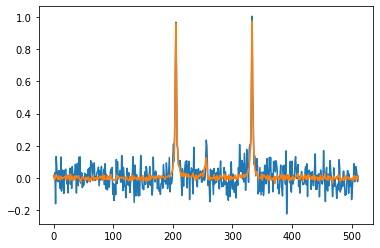

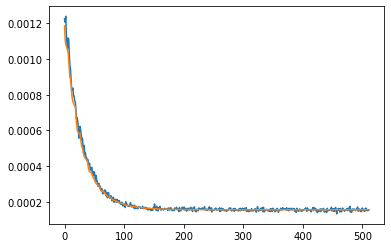

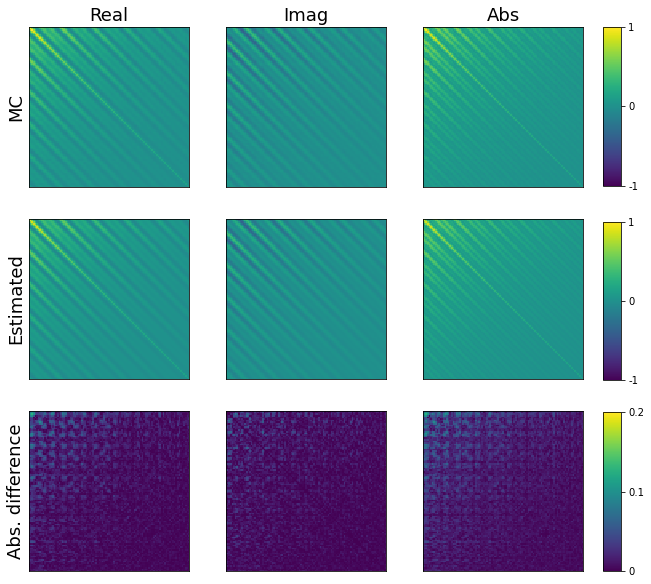

In [484]:
mc_cov_4, est_cov_4, data_4 = run_covariance_analysis(multi_peak_3, 0.1, repetitions=500)

plt.plot(FID2Spec(data_4[1][32,:]).real)
plt.plot(FID2Spec(data_4[2][32,:]).real)
plt.show()

plt.plot(np.diag(mc_cov_4).real)
plt.plot(np.diag(est_cov_4).real)
plt.show()

plot_real_imag(mc_cov_4, est_cov_4, error_display=0.2, limit=100)

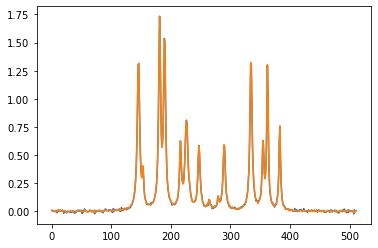

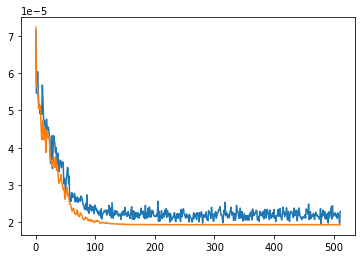

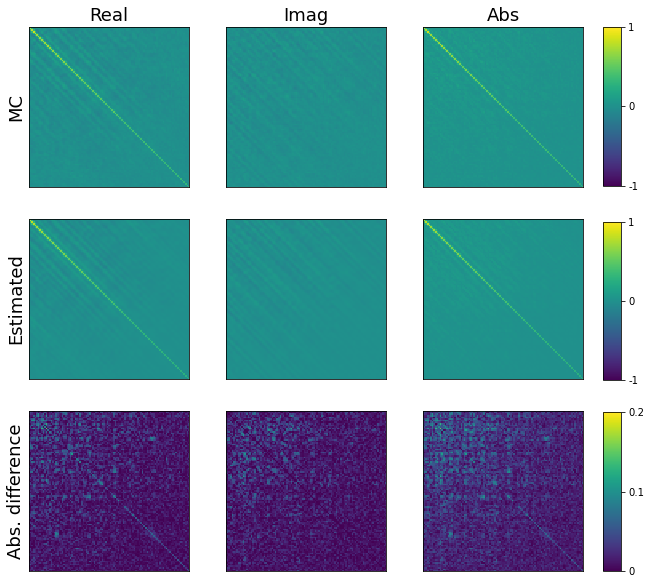

In [439]:
mc_cov_5, est_cov_5, data_5 = run_covariance_analysis(multi_peak, 0.01, repetitions=500)

plt.plot(FID2Spec(data_5[1][32,:]).real)
plt.plot(FID2Spec(data_5[2][32,:]).real)
plt.show()

plt.plot(np.diag(mc_cov_5).real)
plt.plot(np.diag(est_cov_5).real)
plt.show()

plot_real_imag(mc_cov_5, est_cov_5, error_display=0.2, limit=100)

## High and low noise case

In [475]:
# Run simulations
mc_cov_1, est_cov_1, data_1 = run_covariance_analysis(random_mat, 1, repetitions=1000)
mc_cov_2, est_cov_2, data_2 = run_covariance_analysis(single_peak_on, 0.1, repetitions=500)
mc_cov_3, est_cov_3, data_3 = run_covariance_analysis(single_peak_off, 0.1, repetitions=500)
mc_cov_4, est_cov_4, data_4 = run_covariance_analysis(multi_peak_3, 0.1, repetitions=500)
mc_cov_5, est_cov_5, data_5 = run_covariance_analysis(multi_peak, 0.1, repetitions=500)

mc_list_high = [mc_cov_1,mc_cov_2,mc_cov_3,mc_cov_4,mc_cov_5]
est_list_high = [est_cov_1,est_cov_2,est_cov_3,est_cov_4,est_cov_5]
data_high = [data_1,data_2,data_3,data_4,data_5]


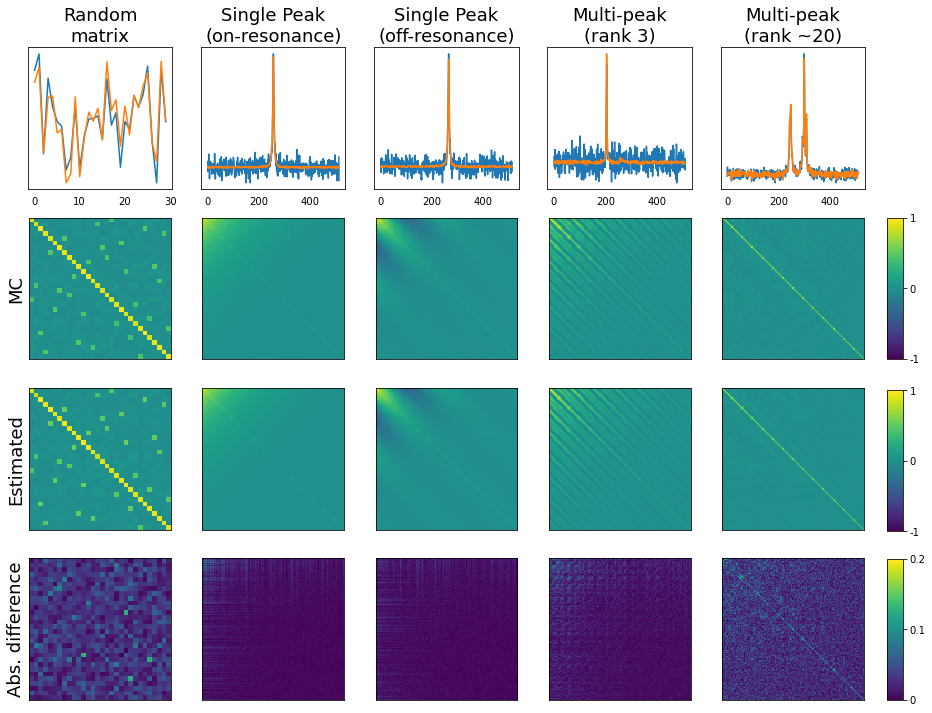

In [487]:
plot_combined(mc_list_high, est_list_high, data_high,'../figures/supp_fig_covar_high.png', error_display=0.2, limit=128)

In [479]:
# Run simulations
mc_cov_1, est_cov_1, data_1 = run_covariance_analysis(random_mat, 0.1, repetitions=1000)
mc_cov_2, est_cov_2, data_2 = run_covariance_analysis(single_peak_on, 0.01, repetitions=500)
mc_cov_3, est_cov_3, data_3 = run_covariance_analysis(single_peak_off, 0.01, repetitions=500)
mc_cov_4, est_cov_4, data_4 = run_covariance_analysis(multi_peak_3, 0.01, repetitions=500)
mc_cov_5, est_cov_5, data_5 = run_covariance_analysis(multi_peak, 0.01, repetitions=500)

mc_list_low = [mc_cov_1,mc_cov_2,mc_cov_3,mc_cov_4,mc_cov_5]
est_list_low = [est_cov_1,est_cov_2,est_cov_3,est_cov_4,est_cov_5]
data_low = [data_1,data_2,data_3,data_4,data_5]

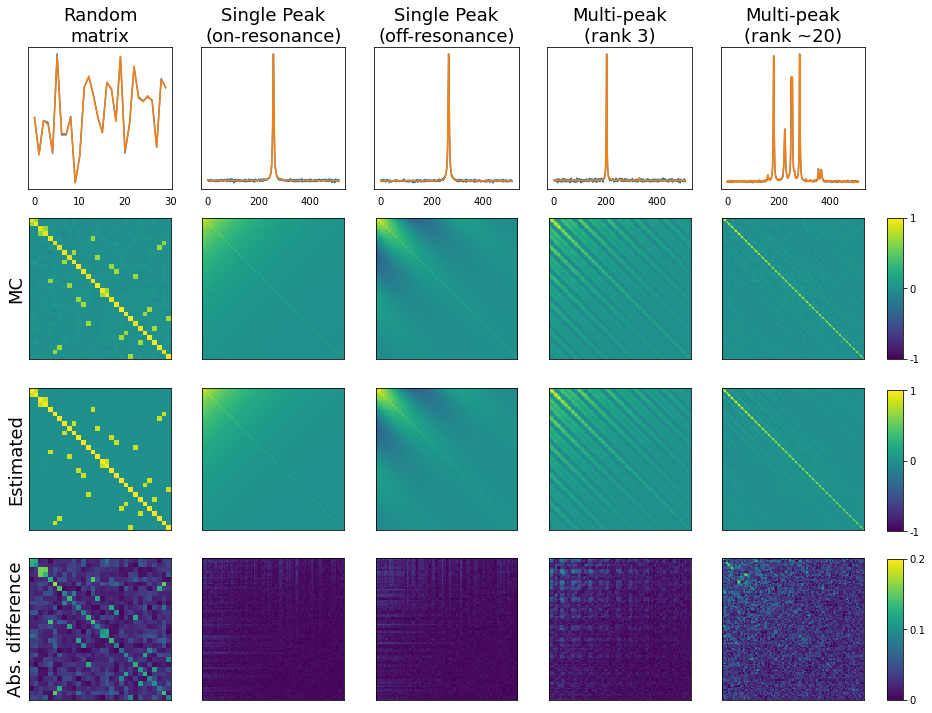

In [488]:
plot_combined(mc_list_low, est_list_low, data_low,'../figures/supp_fig_covar_low.png', error_display=0.2, limit=100)

### Error calculations

In [492]:
print('High noise')
for idx, (mc_cov, est_cov) in enumerate(zip(mc_list_high, est_list_high)):
    error = np.abs(est_cov-mc_cov)/np.max(np.abs(mc_cov))
    mean_error = 100*np.mean(error)
    max_error = 100*np.max(error)
    print(f'Case {idx}: mean={mean_error:0.2f}%, max={max_error:0.2f}%')
    
print('Low noise')
for idx, (mc_cov, est_cov) in enumerate(zip(mc_list_low, est_list_low)):
    error = np.abs(est_cov-mc_cov)/np.max(np.abs(mc_cov))
    mean_error = 100*np.mean(error)
    max_error = 100*np.max(error)
    print(f'Case {idx}: mean={mean_error:0.2f}%, max={max_error:0.2f}%')

High noise
Case 0: mean=3.09%, max=12.87%
Case 1: mean=0.50%, max=7.86%
Case 2: mean=0.53%, max=4.58%
Case 3: mean=0.67%, max=9.53%
Case 4: mean=2.52%, max=18.41%
Low noise
Case 0: mean=3.18%, max=17.49%
Case 1: mean=0.51%, max=4.76%
Case 2: mean=0.56%, max=6.96%
Case 3: mean=0.67%, max=14.30%
Case 4: mean=2.44%, max=15.98%
